In [16]:
# Import all necessary packages
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


In [7]:
train_file = 'C:\Users\Gouth_000\Desktop\Data Scientist Python\House Prices\House_train.csv'
train_df = pd.read_csv(train_file)
Price = train_df.loc[:,'SalePrice'] 


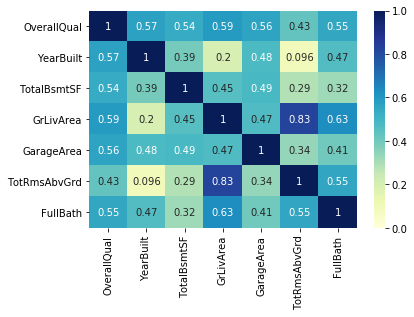

In [8]:
df_imp = train_df.loc[:, ['OverallQual','YearBuilt','TotalBsmtSF','GrLivArea','GarageArea','TotRmsAbvGrd','FullBath']]
corr=df_imp.corr()
sns.heatmap(corr,vmin=0,vmax=1,cmap="YlGnBu",annot=True)
plt.show()

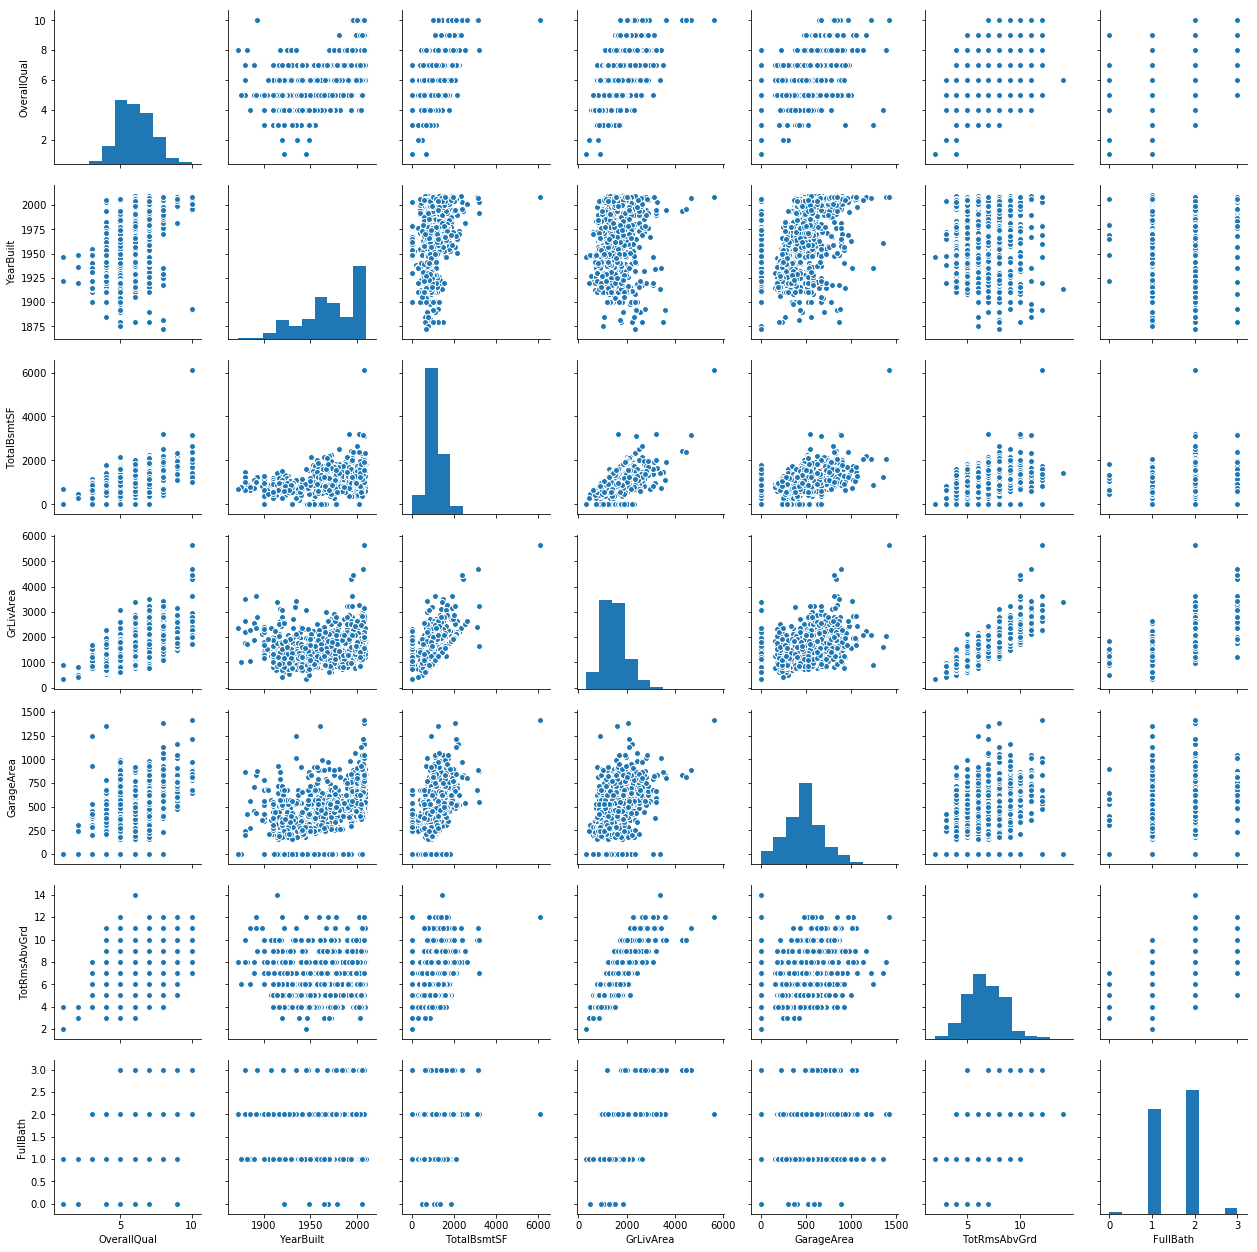

In [9]:
sns.pairplot(df_imp)
plt.show()

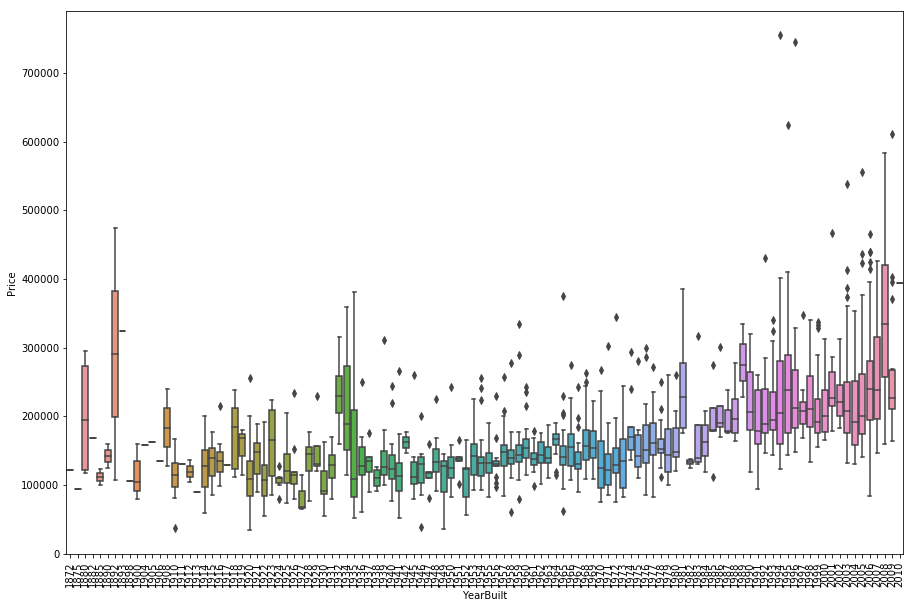

In [10]:
# Let's look at a closer look of the individual variables vs. SalePrice. Starting with the year built. 
df_imp['Price'] = Price
plt.rcParams['figure.figsize'] = [15, 10]
sns.boxplot('YearBuilt','Price',data=df_imp)
plt.xticks(rotation=90)
plt.show()

Looking for missing data and outliers 

In [1]:
df_imp.isnull().sum()

NameError: name 'df_imp' is not defined

In [ ]:

plt.scatter(df_imp['GrLivArea'],Price)
plt.show()

Looks like there are two outliers at the bottom right. We will try and get rid of them for now as they are special cases. 

In [11]:
df_imp.sort_values(by='GrLivArea', ascending=False)[:2]
df_imp = df_imp.drop(df_imp.index[1298])
df_imp = df_imp.drop(df_imp.index[523])
df_imp['Price'] = np.log(df_imp['Price'])
df_imp['GrLivArea'] = np.log(df_imp['GrLivArea'])
df_imp = df_imp.drop(['TotalBsmtSF','TotRmsAbvGrd'],1)
df_imp.columns = ['OverallQual','YearBuilt','Log GrLivArea','GarageArea','FullBath','Log Price']
x = df_imp.loc[:, ['OverallQual','YearBuilt','Log GrLivArea','GarageArea','FullBath']]
y = df_imp.loc[:, 'Log Price']


In [12]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_imp,test_size=0.33,random_state=42)
x_train = train.loc[:, train.columns != 'Log Price']
y_train = train[train.columns[-1:]]
x_test = test.loc[:, test.columns != 'Log Price']
y_test = test[test.columns[-1:]]

In [ ]:
# Apply a GridSearch for optimal Ridge Regression
parameters = {'alpha': np.arange(0.1,1,0.1)}
gd2 = GridSearchCV(estimator=Ridge(),param_grid=parameters)
gd2.fit(x_train,y_train)
ridge_predict = gd2.predict(x_test)
print(gd2.best_estimator_)


In [ ]:
Instead of train test split, we will try cross-validation to see if the model performs better.

In [50]:
# Ridge Regression Prediction

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge

Ridge_reg = Ridge(alpha=0.9)
Ridge_score = np.sqrt(-cross_val_score(Ridge_reg,x_train,y_train,scoring='neg_mean_squared_error',cv=10))
print(Ridge_score.mean())




0.167341486311


In [ ]:
# Attempting to Use ensembling methods, specifically Gradient Boosting 
parameters = {'n_estimators':np.arange(100,1000,100),'learning_rate':np.arange(0.1,1,0.1)}
gd3= GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=parameters)
gd3.fit(x_train,y_train)
print(gd3.best_score_)
print(gd3.best_estimator_)



It looks like Ridge Regression performed the best ! Our model is ready to predict on testing data-set. 

Let's try Lasso Regression


0.167349333492


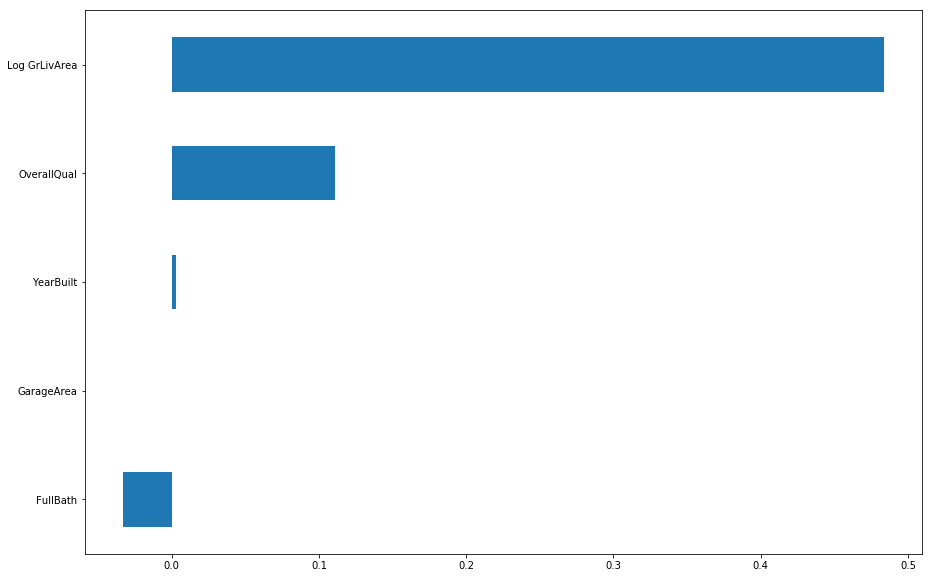

In [57]:
alphas=[1, 0.1,0.001,0.0005]
model_lasso = LassoCV(alphas=alphas)
model_lasso.fit(x_train,y_train)
model_predict = model_lasso.predict(x_test)

RMSE = np.sqrt(-cross_val_score(model_lasso,x_train,y_train,scoring='neg_mean_squared_error',cv=10))
print(RMSE.mean())
coeff = pd.Series(model_lasso.coef_,index=x_train.columns)
coeff.sort_values().plot(kind='barh')
plt.show()

It looks like GarageArea and YearBuilt were pretty irrelevant to the predicting. Let's drop those columns

In [63]:
x_train_new = x_train.drop(['GarageArea'],axis=1)
RMSE = np.sqrt(-cross_val_score(model_lasso,x_train_new,y_train,scoring='neg_mean_squared_error',cv=10))
print(RMSE.mean())

0.176707236649


Looks like that made it worse...

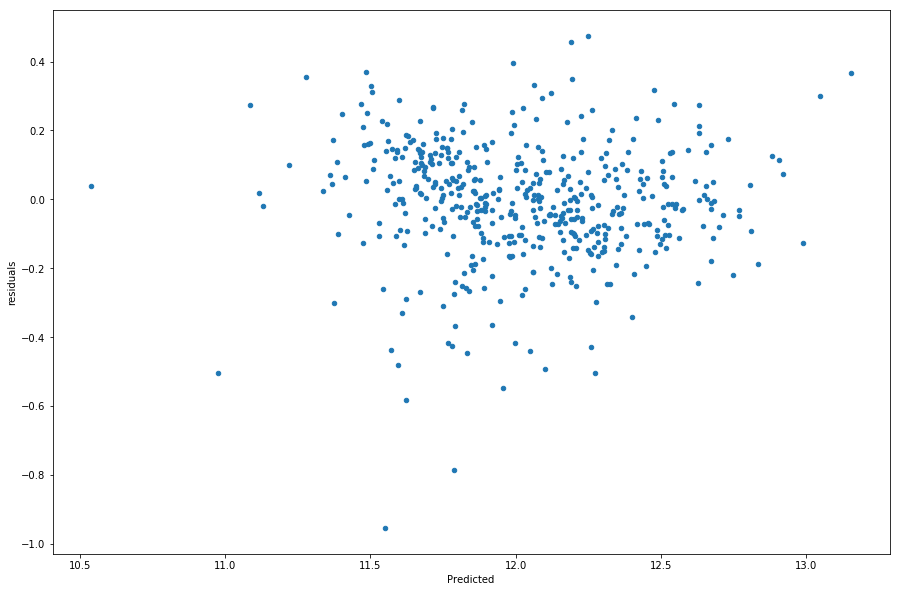

In [85]:
y_pred = model_lasso.predict(x_test)
d = {'Predicted':y_pred,'Actual':y_test['Log Price']}
error = pd.DataFrame(data=d)
error['residuals'] = error['Actual'] - error['Predicted']
error.plot(x='Predicted',y='residuals',kind='scatter')
plt.show()

Let's try a Gradient Boosting

In [89]:
parameters = {'n_estimators':np.arange(100,1000,200)}
gd3= GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=parameters)
RMSE = np.sqrt(-cross_val_score(gd3,x_train,y_train,scoring='neg_mean_squared_error',cv=10))
print(RMSE.mean())

0.169228198612
